#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error,r2_score

from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.decomposition import PCA

import pprint

#Loading data

In [2]:
train = pd.read_csv("TRAIN.csv")
test = pd.read_csv("TEST_FINAL.csv")

In [3]:
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [4]:
train.shape

(188340, 10)

#Data Preprocessing

In [5]:
train.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales'],
      dtype='object')

In [6]:
col_map={
    'ID':'id',
    'Store_id':'storeId',
    'Store_Type':'storeType',
    'Location_Type':'location',
    'Region_Code':'region',
    'Date':'date',
    'Holiday':'holiday',
    'Discount':'discount',
    '#Order':'order',
    'Sales':'sales'
}
train.rename(columns = col_map, inplace = True)

In [7]:
train.columns

Index(['id', 'storeId', 'storeType', 'location', 'region', 'date', 'holiday',
       'discount', 'order', 'sales'],
      dtype='object')

In [8]:
train["discount"] = train["discount"].apply(lambda x : 1 if x =='Yes' else 0)

In [9]:
train['date'] = pd.to_datetime(train.date)

#EDA

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         188340 non-null  object        
 1   storeId    188340 non-null  int64         
 2   storeType  188340 non-null  object        
 3   location   188340 non-null  object        
 4   region     188340 non-null  object        
 5   date       188340 non-null  datetime64[ns]
 6   holiday    188340 non-null  int64         
 7   discount   188340 non-null  int64         
 8   order      188340 non-null  int64         
 9   sales      188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 14.4+ MB


In [11]:
train.isnull().sum()

id           0
storeId      0
storeType    0
location     0
region       0
date         0
holiday      0
discount     0
order        0
sales        0
dtype: int64

In [12]:
train.duplicated().sum()

0

In [13]:
train.describe()

,storeId,holiday,discount,order,sales
count,188340.000000,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,0.447536,68.205692,42784.327982
std,105.366308,0.338256,0.497241,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,1.000000,82.000000,51909.000000
max,365.000000,1.000000,1.000000,371.000000,247215.000000


<Axes: >

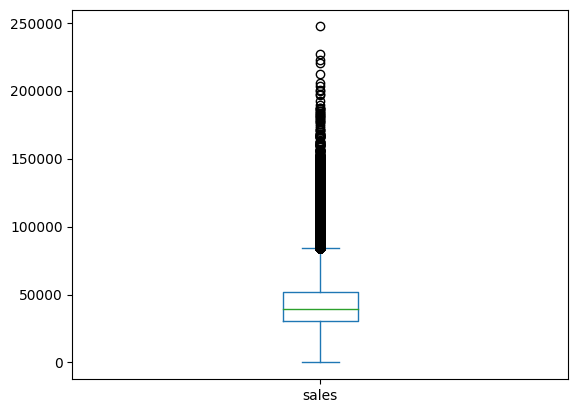

In [14]:
train['sales'].plot(kind='box')

<Axes: xlabel='sales', ylabel='Count'>

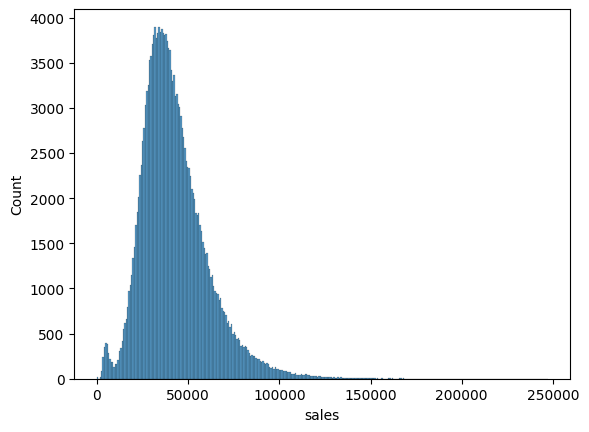

In [15]:
sns.histplot(train,x="sales")

<Axes: xlabel='discount', ylabel='sales'>

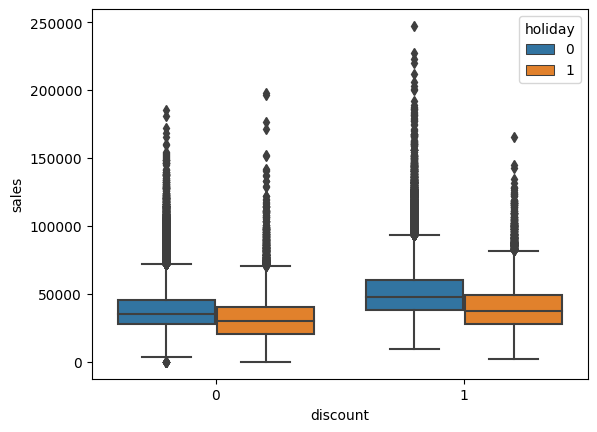

In [16]:
sns.boxplot(train,y="sales",x="discount",hue="holiday")

<Axes: xlabel='discount', ylabel='sales'>

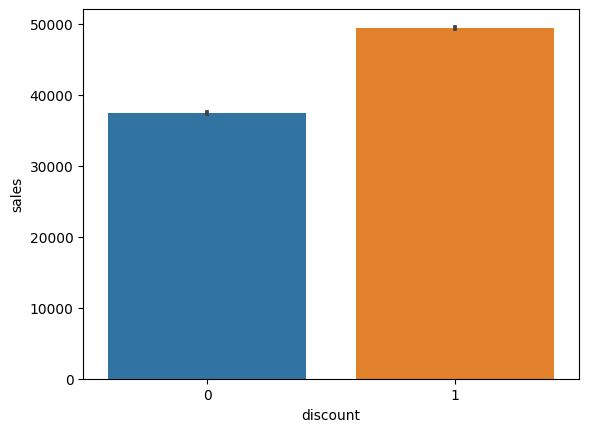

In [17]:
sns.barplot(train,x="discount",y="sales")

<Axes: xlabel='region', ylabel='sales'>

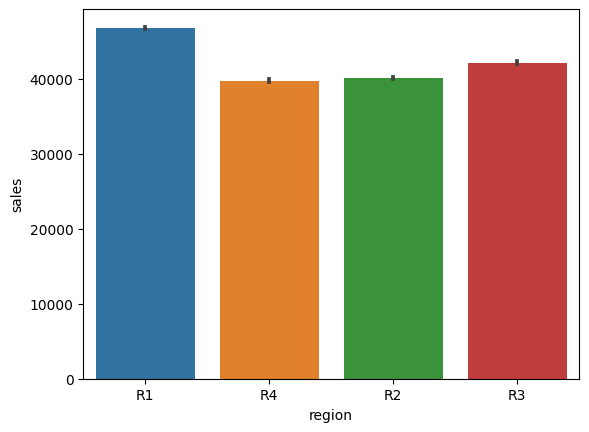

In [18]:
sns.barplot(train,x="region",y="sales")

<Axes: xlabel='storeId', ylabel='sales'>

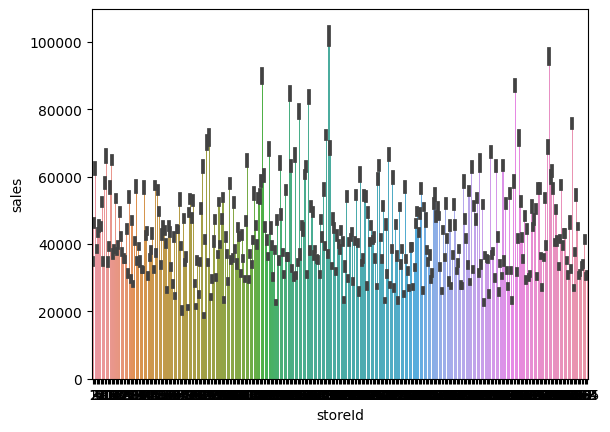

In [19]:
sns.barplot(train,x="storeId",y="sales")

In [20]:
best_stores = train.groupby("storeId")['sales'].sum().sort_values(ascending=False)[:20]

In [21]:
best_stores

storeId
175    52560255.15
337    49342417.92
126    46351830.51
312    44890318.23
146    43697690.67
160    43171935.06
153    40906471.74
354    39130625.88
173    37387163.25
87     36934016.67
315    36815851.53
85     36205553.67
336    35473797.60
176    35366293.20
131    35171306.64
294    34772865.12
219    34325395.50
150    34291233.18
11     34084541.91
15     33536867.64
Name: sales, dtype: float64

<Axes: xlabel='storeType', ylabel='sales'>

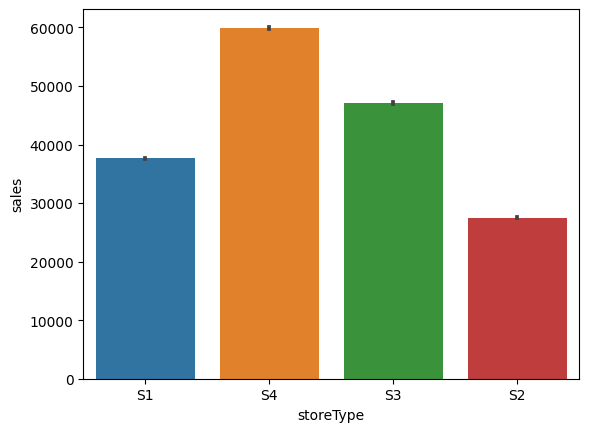

In [22]:
sns.barplot(train,x="storeType",y="sales")

In [23]:
best_store_type = train.groupby("storeType")['sales'].sum().sort_values(ascending=False)

In [24]:
best_store_type

storeType
S1    3.343866e+09
S4    2.752946e+09
S3    1.165658e+09
S2    7.955308e+08
Name: sales, dtype: float64

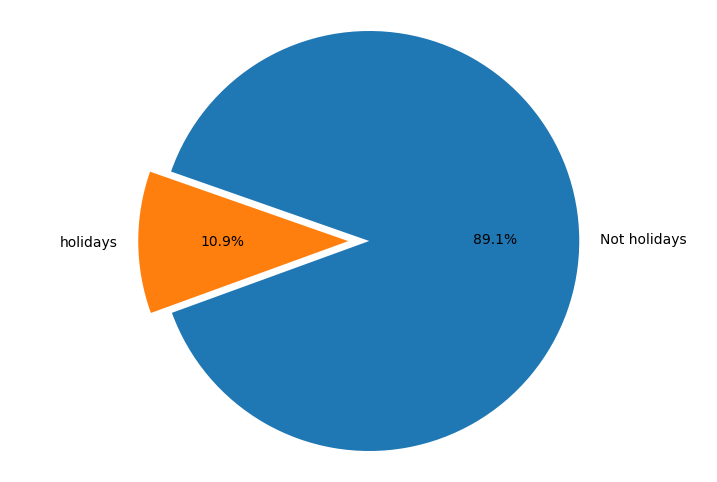

In [25]:
holiday = train.groupby(['holiday'], as_index=False)['sales'].sum()
holiday['holiday'] = holiday['holiday'].astype(str)

fig = plt.figure(figsize =(9, 6))

plt.pie(holiday['sales'],
        explode=(0.1, 0),
        labels=['Not holidays', 'holidays'],
        autopct='%1.1f%%',
        startangle=200)

plt.axis('equal')

plt.show()

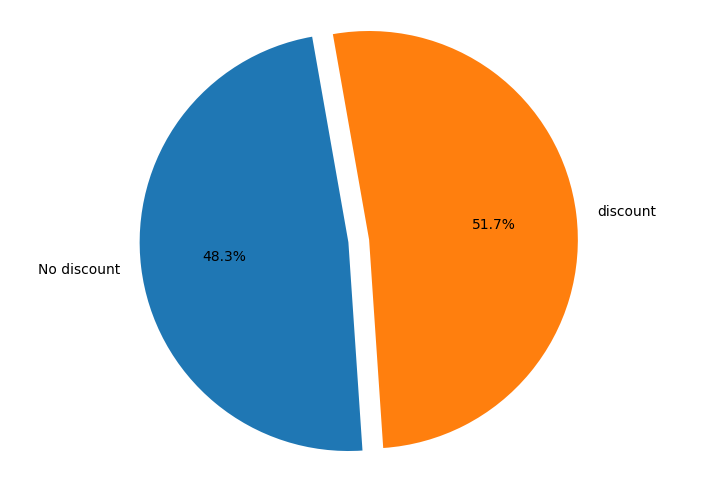

In [26]:
discount = train.groupby(['discount'], as_index=False)['sales'].sum()
discount['discount'] = discount['discount'].astype(str)

fig = plt.figure(figsize =(9, 6))

plt.pie(discount['sales'],
        explode=(0.1, 0),
        labels=['No discount', 'discount'],
        autopct='%1.1f%%',
        startangle=100)

plt.axis('equal')

plt.show()

#Feature Engineering

In [27]:
train.columns

Index(['id', 'storeId', 'storeType', 'location', 'region', 'date', 'holiday',
       'discount', 'order', 'sales'],
      dtype='object')

In [28]:
train = train.drop('id',axis=1)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   storeId    188340 non-null  int64         
 1   storeType  188340 non-null  object        
 2   location   188340 non-null  object        
 3   region     188340 non-null  object        
 4   date       188340 non-null  datetime64[ns]
 5   holiday    188340 non-null  int64         
 6   discount   188340 non-null  int64         
 7   order      188340 non-null  int64         
 8   sales      188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 12.9+ MB


In [30]:
train.head()

,storeId,storeType,location,region,date,holiday,discount,order,sales
0,1,S1,L3,R1,2018-01-01,1,1,9,7011.84
1,253,S4,L2,R1,2018-01-01,1,1,60,51789.12
2,252,S3,L2,R1,2018-01-01,1,1,42,36868.20
3,251,S2,L3,R1,2018-01-01,1,1,23,19715.16
4,250,S2,L3,R4,2018-01-01,1,1,62,45614.52


In [31]:
categ_cols = train.dtypes[train.dtypes == 'object']
categ_cols = categ_cols.index.tolist()
train = pd.get_dummies(train, columns=categ_cols, drop_first=True)

In [32]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.weekday
train['quarter'] = train['date'].dt.quarter

In [33]:
train = train.drop(['date'], axis = 1)
train = pd.get_dummies(train, columns=['year'], drop_first=True, prefix='year')
train = pd.get_dummies(train, columns=['month'], drop_first=True, prefix='month')
train = pd.get_dummies(train, columns=['week'], drop_first=True, prefix='week')
train = pd.get_dummies(train, columns=['quarter'], drop_first=True, prefix='quarter')

In [34]:
train.head()

,storeId,holiday,discount,order,sales,storeType_S2,storeType_S3,storeType_S4,location_L2,location_L3,...,month_12,week_1,week_2,week_3,week_4,week_5,week_6,quarter_2,quarter_3,quarter_4
0,1,1,1,9,7011.84,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,253,1,1,60,51789.12,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,252,1,1,42,36868.20,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,251,1,1,23,19715.16,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,250,1,1,62,45614.52,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
drop_cols = train.corr()['sales'].abs().sort_values()[:5].index

In [36]:
train = train.drop(drop_cols,axis=1)

In [37]:
train['holidayAndDiscount'] = train['holiday'] * train['discount']

In [38]:
q1 = train['sales'].quantile(0.25)
q3 = train['sales'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['sales'])
for i in train['sales']:
    if i > Upper_tail or i < Lower_tail:
            train['sales'] = train['sales'].replace(i, med)

In [39]:
train['sales'] = MinMaxScaler().fit_transform(np.array(train['sales']).reshape(-1,1))

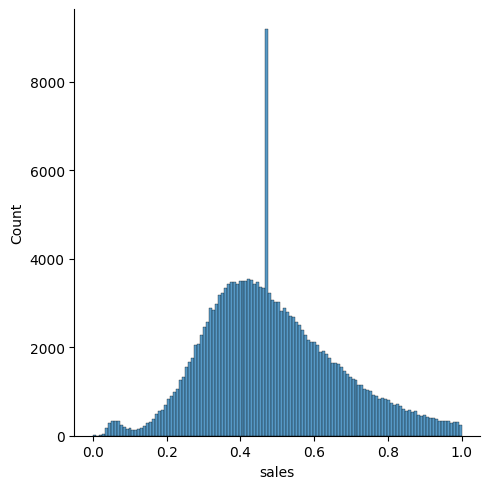

In [40]:
sns.displot(train['sales'])

#Visualisation

In [41]:
X = train.drop('sales',axis=1)
Y = train['sales']

In [42]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.7)

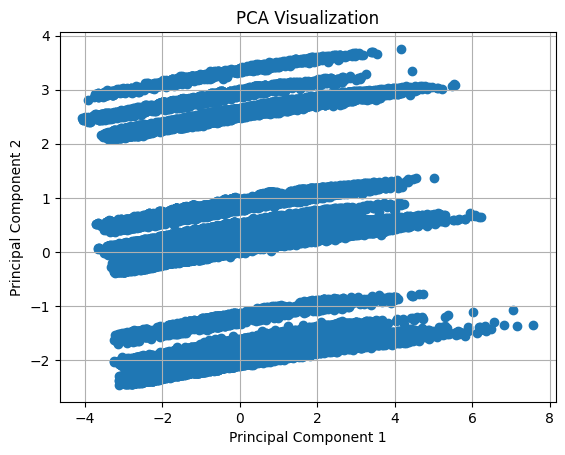

In [43]:
X = x_train.copy()

X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

# Step 3: Perform PCA
pca = PCA(n_components=2)  # You can choose the number of components as per your requirement
X_pca = pca.fit_transform(X_standardized)

# Step 4: Choose the Number of Components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 5: Visualize the data in a 2D space
plt.scatter(X_pca[:, 0], X_pca[:, 1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.grid(True)
plt.show()


#Modeling

In [44]:
def baseline_modelling(models,x_train,x_test,y_train,y_test):

  scores={}

  for mod in models:
    print(f"Training Model:{mod['name']}")
    model = mod['model']
    model.fit(x_train,y_train)
    pred = model.predict(x_test).reshape(-1)
    scores[mod['name']] = {'mss': mean_squared_error(y_test,pred),'r2': r2_score(y_test,pred)}
    print(scores[mod['name']])
  pprint.pprint(scores)
  return scores

In [48]:
models = [
    {'name':'ridge','model':Ridge()},
    {'name':'SVR','model':SVR()},
    {'name':'XGB','model':XGBRegressor()},
    {'name':'GB','model':GradientBoostingRegressor()},
    {'name':'EX','model':RandomForestRegressor()}

]
baseline_modelling(models,x_train,x_test,y_train,y_test)

Training Model:ridge
{'mss': 0.01061862751175487, 'r2': 0.6684697968393869}
Training Model:SVR
{'mss': 0.00479198832354961, 'r2': 0.8503866096921657}
Training Model:XGB
{'mss': 0.003485674822878733, 'r2': 0.891171765757716}
Training Model:GB
{'mss': 0.004181703375379031, 'r2': 0.8694406628293417}
Training Model:EX
{'mss': 0.004240161582798661, 'r2': 0.8676155059189237}
{'EX': {'mss': 0.004240161582798661, 'r2': 0.8676155059189237},
 'GB': {'mss': 0.004181703375379031, 'r2': 0.8694406628293417},
 'SVR': {'mss': 0.00479198832354961, 'r2': 0.8503866096921657},
 'XGB': {'mss': 0.003485674822878733, 'r2': 0.891171765757716},
 'ridge': {'mss': 0.01061862751175487, 'r2': 0.6684697968393869}}


{'ridge': {'mss': 0.01061862751175487, 'r2': 0.6684697968393869},
 'SVR': {'mss': 0.00479198832354961, 'r2': 0.8503866096921657},
 'XGB': {'mss': 0.003485674822878733, 'r2': 0.891171765757716},
 'GB': {'mss': 0.004181703375379031, 'r2': 0.8694406628293417},
 'EX': {'mss': 0.004240161582798661, 'r2': 0.8676155059189237}}

In [49]:
grid = {}
grid['n_estimators'] = [150, 200]
grid['learning_rate'] = [0.1,0.15]
grid['subsample'] = [0.9,1.0]
grid['max_depth'] = [5,9]

gbr = GradientBoostingRegressor(

)

gsearch = GridSearchCV(
    estimator= gbr,
    param_grid= grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=4,
)


bgbr = gsearch.fit(X=x_train[:10000], y=y_train[:10000])

(gsearch.best_params_, gsearch.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0},
 -0.004226467825659991)

In [50]:
models = [
    {'name':'gb','model':GradientBoostingRegressor(
        learning_rate= 0.1,
        max_depth= 5,
        n_estimators= 150,
        subsample = 1
    )}
]
baseline_modelling(models,x_train,x_test,y_train,y_test)

Training Model:gb
{'mss': 0.0035959930783268403, 'r2': 0.8877274568203747}
{'gb': {'mss': 0.0035959930783268403, 'r2': 0.8877274568203747}}


{'gb': {'mss': 0.0035959930783268403, 'r2': 0.8877274568203747}}

In [51]:
models = [
    {'name':'gb','model':GradientBoostingRegressor(
        learning_rate= 0.1,
        max_depth= 9,
        n_estimators= 150,
        subsample = 1
    )}
]

In [52]:
baseline_modelling(models,x_train,x_test,y_train,y_test)

Training Model:gb
{'mss': 0.003531906976699303, 'r2': 0.8897283254136866}
{'gb': {'mss': 0.003531906976699303, 'r2': 0.8897283254136866}}


{'gb': {'mss': 0.003531906976699303, 'r2': 0.8897283254136866}}

In [53]:
models = [
    {'name':'gb','model':GradientBoostingRegressor(
        learning_rate= 0.15,
        max_depth= 5,
        n_estimators= 200,
        subsample = 0.9
    )}
]
baseline_modelling(models,x_train,x_test,y_train,y_test)

Training Model:gb
{'mss': 0.0034759172752111436, 'r2': 0.8914764116977872}
{'gb': {'mss': 0.0034759172752111436, 'r2': 0.8914764116977872}}


{'gb': {'mss': 0.0034759172752111436, 'r2': 0.8914764116977872}}

#Results

The model has been trained with a mean square error of just 0.0034